In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 50.0MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.49MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.6MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.39MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


In [17]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [18]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [15]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

#Batch size 128

In [14]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [16]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [19]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7806538276672363, accuracy: 76.54791666666667
Epoch 0: val. loss: 0.767106350432051, val. accuracy: 76.73333333333333
Epoch 1: training loss: 0.41625854825973513, accuracy: 88.47916666666666
Epoch 1: val. loss: 0.40935863174022513, val. accuracy: 88.05833333333334
Epoch 2: training loss: 0.3186796249548594, accuracy: 91.0875
Epoch 2: val. loss: 0.31332010157564855, val. accuracy: 91.10000000000001
Epoch 3: training loss: 0.24215688641866048, accuracy: 93.15625
Epoch 3: val. loss: 0.24053043903822593, val. accuracy: 93.025
Epoch 4: training loss: 0.20670894743998847, accuracy: 94.06041666666667
Epoch 4: val. loss: 0.20899200788203706, val. accuracy: 93.85833333333333
CPU times: user 1min 20s, sys: 208 ms, total: 1min 20s
Wall time: 1min 21s


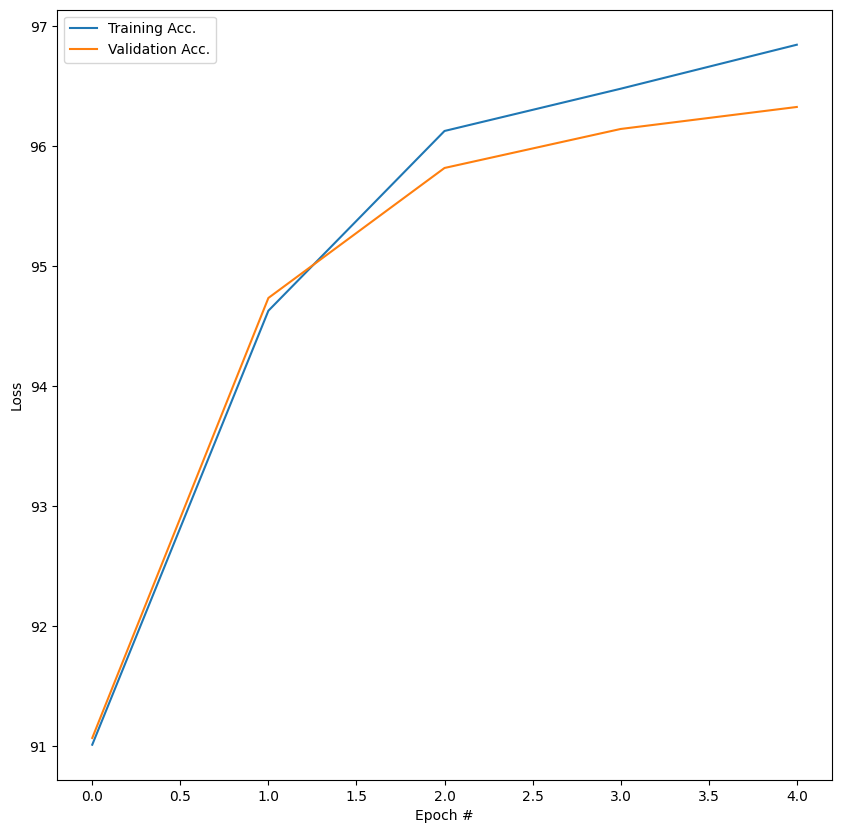

In [23]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

#Batch Size 32

In [20]:
batch_size = 32

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [21]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [22]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.3058761025716861, accuracy: 91.01041666666667
Epoch 0: val. loss: 0.29830268759528794, val. accuracy: 91.06666666666666
Epoch 1: training loss: 0.18144171013620994, accuracy: 94.62708333333333
Epoch 1: val. loss: 0.18166694401701292, val. accuracy: 94.73333333333333
Epoch 2: training loss: 0.13067591596146425, accuracy: 96.125
Epoch 2: val. loss: 0.1398473261271914, val. accuracy: 95.81666666666668
Epoch 3: training loss: 0.11824525807782386, accuracy: 96.47708333333334
Epoch 3: val. loss: 0.13063713426639637, val. accuracy: 96.14166666666667
Epoch 4: training loss: 0.10468916567709918, accuracy: 96.84375
Epoch 4: val. loss: 0.12293086209023993, val. accuracy: 96.325
CPU times: user 1min 40s, sys: 284 ms, total: 1min 40s
Wall time: 1min 44s


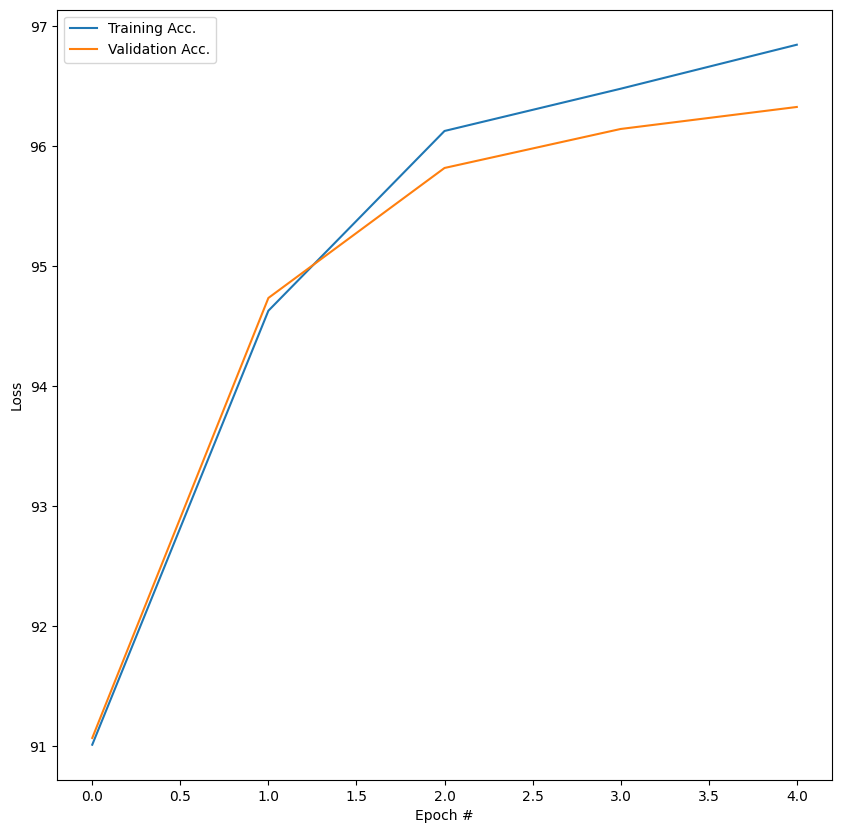

In [24]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

#Batch size 256

In [25]:
batch_size = 256

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [26]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [27]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.006579835998251, accuracy: 45.37291666666667
Epoch 0: val. loss: 2.006805587322154, val. accuracy: 45.36666666666667
Epoch 1: training loss: 0.6953569818684395, accuracy: 80.26875
Epoch 1: val. loss: 0.6894261025367899, val. accuracy: 79.9
Epoch 2: training loss: 0.4540033571897669, accuracy: 87.125
Epoch 2: val. loss: 0.44657600623496035, val. accuracy: 87.125
Epoch 3: training loss: 0.3766874328572699, accuracy: 89.1625
Epoch 3: val. loss: 0.36983798349157293, val. accuracy: 89.10833333333333
Epoch 4: training loss: 0.3314194730780226, accuracy: 90.28333333333333
Epoch 4: val. loss: 0.32393572114883584, val. accuracy: 90.26666666666667
CPU times: user 1min 17s, sys: 209 ms, total: 1min 17s
Wall time: 1min 18s


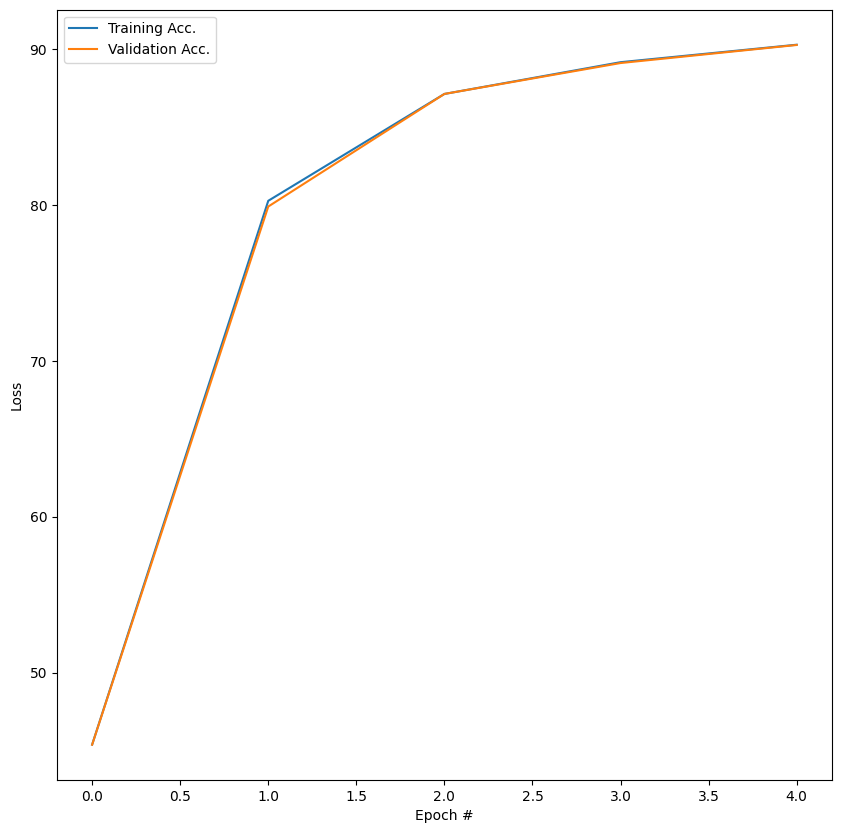

In [28]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

#Learning rate 0.01

In [29]:
batch_size = 256

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [30]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)

In [31]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.2932734933305294, accuracy: 13.125
Epoch 0: val. loss: 2.2928881898839424, val. accuracy: 13.4
Epoch 1: training loss: 2.279456141147208, accuracy: 13.841666666666667
Epoch 1: val. loss: 2.2790443643610527, val. accuracy: 13.941666666666666
Epoch 2: training loss: 2.2553255431195525, accuracy: 20.241666666666667
Epoch 2: val. loss: 2.2548132297840526, val. accuracy: 20.375
Epoch 3: training loss: 2.2011366220230753, accuracy: 29.98125
Epoch 3: val. loss: 2.200424762482339, val. accuracy: 30.349999999999998
Epoch 4: training loss: 2.0454966172258904, accuracy: 41.38333333333333
Epoch 4: val. loss: 2.044162390079904, val. accuracy: 41.53333333333333
CPU times: user 1min 22s, sys: 332 ms, total: 1min 22s
Wall time: 1min 27s


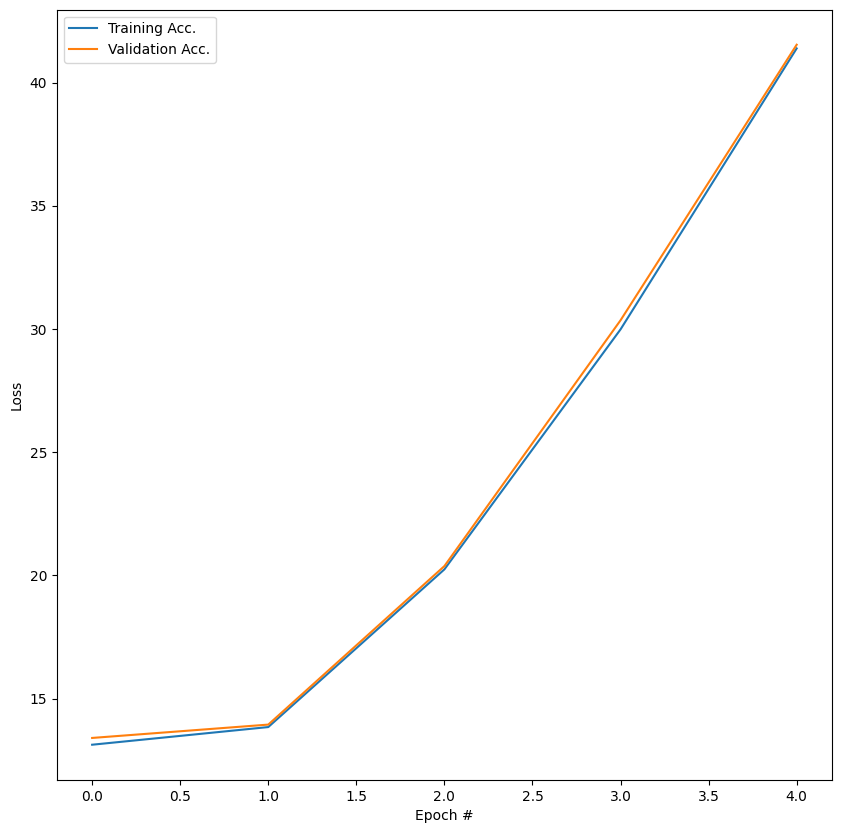

In [32]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

#Learning rate 0.09

In [33]:
batch_size = 256

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [34]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.09)

In [35]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 1.2056132282348389, accuracy: 67.35416666666667
Epoch 0: val. loss: 1.1992785626269402, val. accuracy: 67.325
Epoch 1: training loss: 0.4790258233217483, accuracy: 85.25625
Epoch 1: val. loss: 0.4714526159966246, val. accuracy: 84.99166666666666
Epoch 2: training loss: 0.35168318862610676, accuracy: 89.9875
Epoch 2: val. loss: 0.338883213540341, val. accuracy: 90.0
Epoch 3: training loss: 0.28838173942045964, accuracy: 91.80833333333334
Epoch 3: val. loss: 0.2793974705198978, val. accuracy: 91.65833333333333
Epoch 4: training loss: 0.238207867329425, accuracy: 93.11874999999999
Epoch 4: val. loss: 0.2345390078869272, val. accuracy: 92.99166666666666
CPU times: user 1min 22s, sys: 237 ms, total: 1min 22s
Wall time: 1min 30s


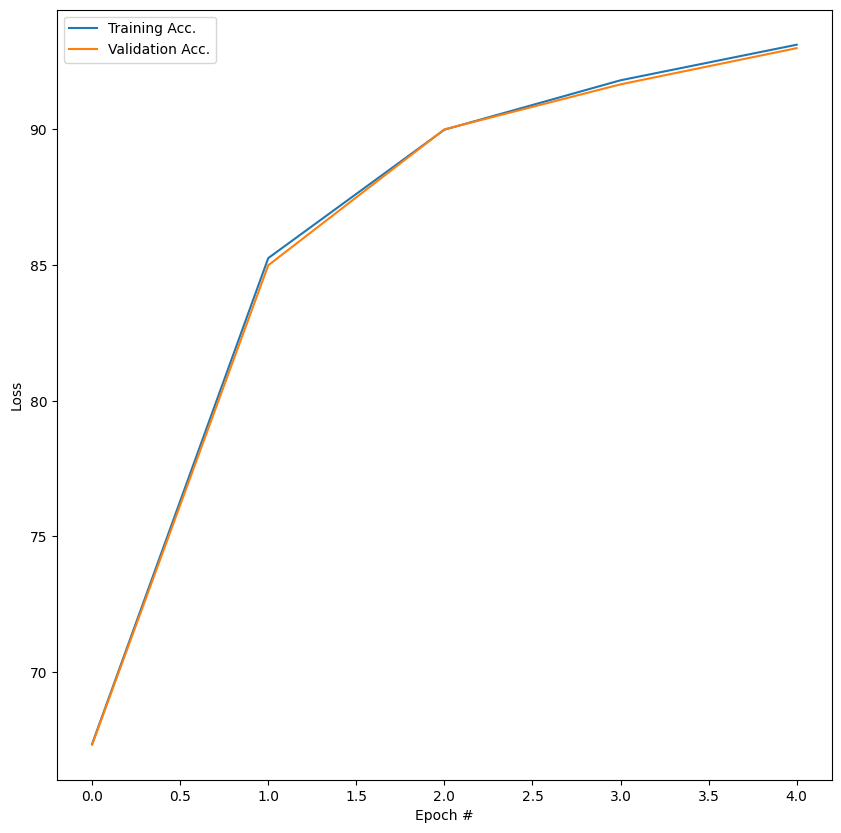

In [36]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

#ELU activation functions

In [49]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [50]:
batch_size = 256

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [51]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.9341473005553509, accuracy: 74.53541666666666
Epoch 0: val. loss: 0.9287960250326928, val. accuracy: 73.91666666666666
Epoch 1: training loss: 0.4865147726649934, accuracy: 86.28125
Epoch 1: val. loss: 0.4793529472452529, val. accuracy: 86.19166666666666
Epoch 2: training loss: 0.3946711688916734, accuracy: 88.65208333333334
Epoch 2: val. loss: 0.3861661134882176, val. accuracy: 88.89166666666667
Epoch 3: training loss: 0.34794489833268716, accuracy: 90.01458333333333
Epoch 3: val. loss: 0.33993058952879396, val. accuracy: 90.05
Epoch 4: training loss: 0.3196778197554832, accuracy: 90.73958333333333
Epoch 4: val. loss: 0.3126247119396291, val. accuracy: 90.77499999999999
CPU times: user 1min 19s, sys: 187 ms, total: 1min 19s
Wall time: 1min 20s


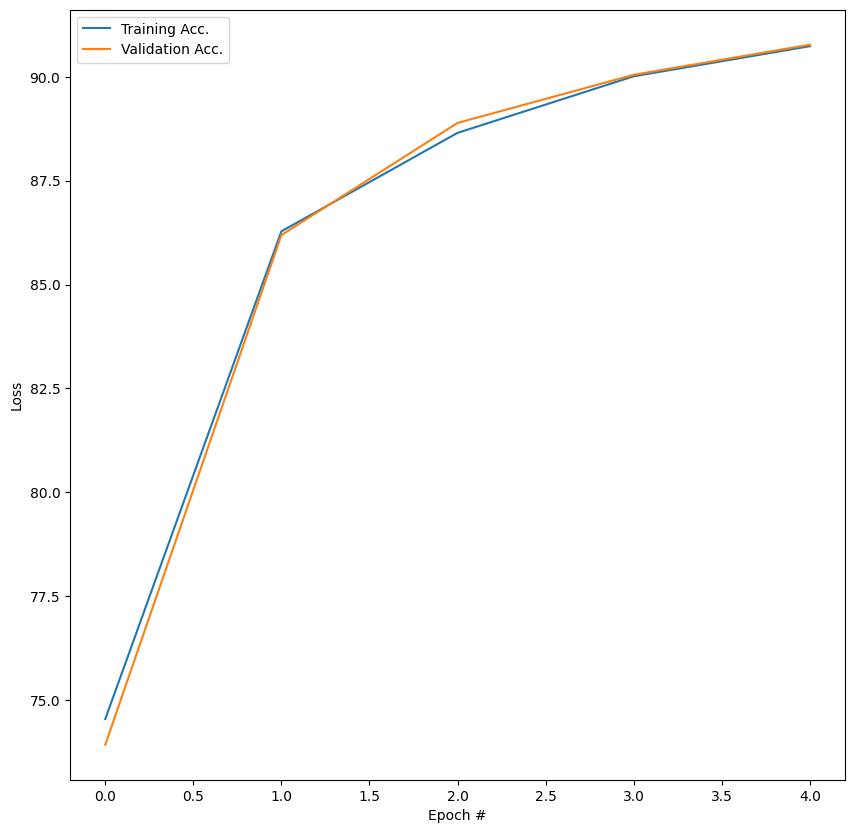

In [52]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

#Tanh activation functions

In [41]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [42]:
batch_size = 256

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [43]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 1.0596858630789088, accuracy: 67.55624999999999
Epoch 0: val. loss: 1.0574577679025365, val. accuracy: 67.89166666666667
Epoch 1: training loss: 0.583868717259549, accuracy: 85.03333333333333
Epoch 1: val. loss: 0.5799549691220547, val. accuracy: 84.8
Epoch 2: training loss: 0.4356497117179505, accuracy: 88.375
Epoch 2: val. loss: 0.42937507274303033, val. accuracy: 88.34166666666667
Epoch 3: training loss: 0.3692635916014935, accuracy: 89.86041666666667
Epoch 3: val. loss: 0.3617933493979434, val. accuracy: 89.95833333333333
Epoch 4: training loss: 0.3351901395523802, accuracy: 90.60208333333334
Epoch 4: val. loss: 0.3280184503565443, val. accuracy: 90.61666666666667
CPU times: user 1min 22s, sys: 264 ms, total: 1min 22s
Wall time: 1min 29s


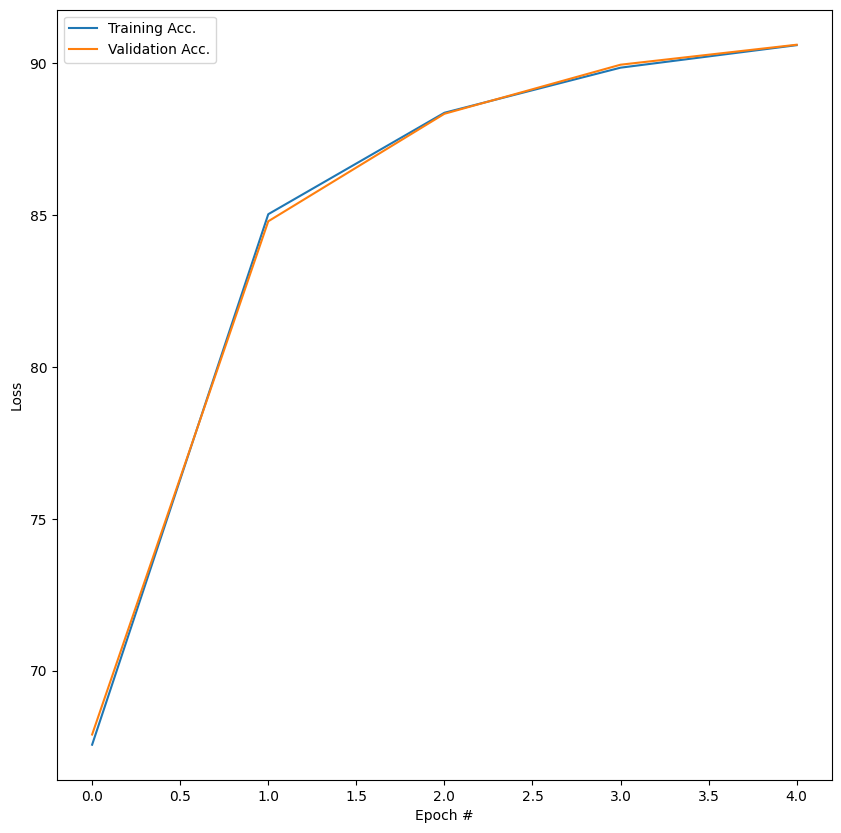

In [44]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

#What is a learning rate scheduler?

A learning rate scheduler is a tool that is used to adjust the learning rate during training. This could be dynamically updated in relation to the loss or it can be as simple as lower the learning rate after a certain number of epochs. Schedulers are very useful tools in improving the speed of training as well as accomplishing specific objectives in learning more difficult tasks (perhaps some areas of training deserve a higher or lower learning rate associated with them).